# 因果構造探索 PoC — PC アルゴリズム / LiNGAM による因果グラフの推定

## 目的
データのみから因果構造を推定し、真の DAG と比較して推定精度を評価する。

## 手法
1. **PC アルゴリズム**: 条件付き独立性検定ベース → CPDAG を出力
2. **DirectLiNGAM**: 非ガウス性・線形性の仮定ベース → 完全な DAG を出力

## 前提
- 入力: `dataset.csv`（変数間の因果構造は未知とする）
- 検証: 真の DAG（DGP で定義済み）と比較

## 注意
- DGP のノイズ項はすべてガウス分布であるため、LiNGAM の非ガウス仮定を満たさない
- LiNGAM がこの条件下でどの程度機能するかも検証対象とする

## 1. データ読み込み

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("dataset.csv")
print(f"データ形状: {df.shape}")
print(f"変数一覧:   {list(df.columns)}")
df.head()

データ形状: (2000, 20)
変数一覧:   ['W1', 'W2', 'Z1', 'Z2', 'Z3', 'IV', 'IV2', 'X', 'M', 'M2', 'P1', 'D1', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'Y']


,W1,W2,Z1,Z2,Z3,IV,IV2,X,M,M2,P1,D1,N1,N2,N3,N4,N5,N6,N7,Y
0,0.304717,0.0,0.442136,-0.367840,1.245193,0.0,0.0,0.599020,0.892969,-0.314386,-0.315520,-0.679524,0.833649,0.368720,0.331567,-0.341520,0.459874,-0.260174,-0.524155,1.809594
1,-1.039984,0.0,-0.541730,-0.026710,2.118210,0.0,0.0,-0.360906,0.789482,-0.063268,-0.564038,-0.900671,0.218746,0.197153,0.345617,-1.183155,1.788644,0.893888,0.012188,0.406691
2,0.750451,1.0,0.388021,0.955412,-1.692561,0.0,0.0,0.577876,-0.514820,0.301276,0.563532,0.233626,0.167060,0.087800,1.346212,0.107567,-0.922418,-0.681000,0.270567,0.893126
3,0.940565,0.0,0.857234,0.234818,-0.388477,0.0,0.0,0.706293,0.176630,0.837447,0.497578,-0.686047,1.095522,0.136618,-1.575544,1.892864,-1.227677,-0.343364,-1.063642,0.435868
4,-1.951035,0.0,-1.314677,0.081896,-0.742267,1.0,1.0,2.067104,0.888376,0.553075,-0.346290,0.008550,-1.699836,0.789668,1.827355,1.834667,0.214235,0.398525,0.174935,1.418514


## 2. PC アルゴリズムによる因果構造探索

causal-learn の PC アルゴリズムを用いて、データから CPDAG を推定する。

- **PC アルゴリズム**: 条件付き独立性検定を繰り返し、変数間のエッジの有無と方向を推定する
- **出力**: CPDAG（向きが確定したエッジ `→` と、確定しない無向エッジ `—` が混在するグラフ）

In [2]:
from causallearn.search.ConstraintBased.PC import pc

data = df.values
column_names = list(df.columns)
n = len(column_names)

# PC アルゴリズムを実行
cg = pc(
    data=data,
    alpha=0.05,
    indep_test="fisherz",
    node_names=column_names,
)

print("PC アルゴリズム実行完了")

  0%|          | 0/20 [00:00<?, ?it/s]

PC アルゴリズム実行完了


## 3. 推定された CPDAG の可視化（単一実行）

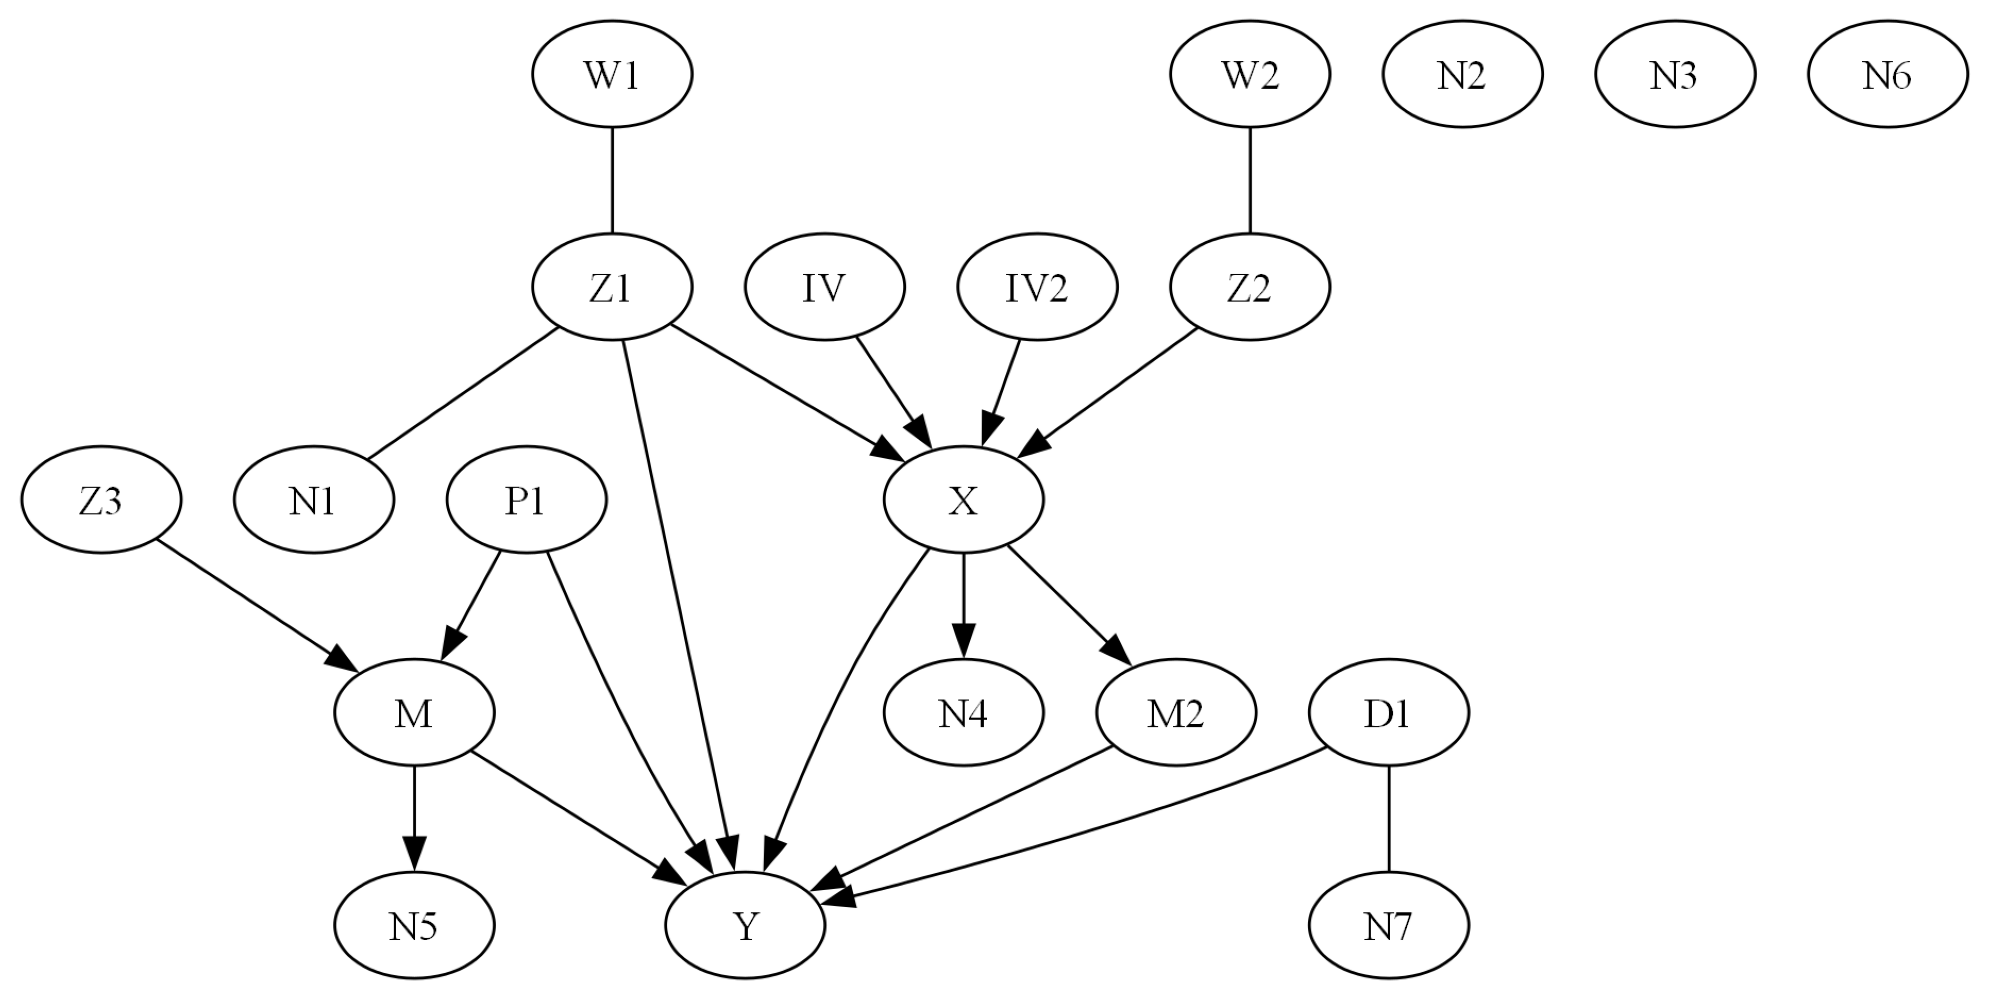

In [3]:
import matplotlib.pyplot as plt

cg.draw_pydot_graph(labels=column_names)
plt.show()

## 4. PC アルゴリズムのブートストラップ

単一実行の結果はサンプリングの偶然に左右されるため、ブートストラップ法でエッジの安定性を評価する。
- データをリサンプリングして PC を 100 回実行
- 各エッジの出現確率を算出し、LiNGAM と同じ閾値 (50%) でフィルタリング

In [4]:
n_bootstrap = 100
# edge_counts[i, j]: (i, j) 位置に非ゼロ値が出現した回数
edge_counts = np.zeros((n, n))

np.random.seed(42)
for b in range(n_bootstrap):
    idx = np.random.choice(len(data), size=len(data), replace=True)
    boot_data = data[idx]
    cg_b = pc(data=boot_data, alpha=0.05, indep_test="fisherz", node_names=column_names)
    adj_b = cg_b.G.graph
    for i in range(n):
        for j in range(n):
            if adj_b[i, j] != 0:
                edge_counts[i, j] += 1

pc_probs = edge_counts / n_bootstrap
pc_probs_df = pd.DataFrame(pc_probs, index=column_names, columns=column_names)
print("PC ブートストラップによるエッジ出現確率:")
print(pc_probs_df.round(3))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

PC ブートストラップによるエッジ出現確率:
       W1    W2    Z1    Z2    Z3    IV   IV2     X     M    M2    P1    D1  \
W1   0.00  0.02  1.00  0.09  0.01  0.02  0.00  0.00  0.00  0.00  0.00  0.00   
W2   0.02  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.13  0.00   
Z1   1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.99  0.00  0.00  0.01  0.00   
Z2   0.09  1.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.01  0.00  0.00   
Z3   0.01  0.00  0.00  0.00  0.00  0.02  0.01  0.00  1.00  0.01  0.00  0.00   
IV   0.02  0.00  0.00  0.00  0.02  0.00  0.01  1.00  0.02  0.41  0.00  0.00   
IV2  0.00  0.00  0.00  0.00  0.01  0.01  0.00  1.00  0.01  0.10  0.00  0.00   
X    0.00  0.00  0.99  1.00  0.00  1.00  1.00  0.00  0.00  1.00  0.00  0.00   
M    0.00  0.00  0.00  0.00  1.00  0.02  0.01  0.00  0.00  0.00  1.00  0.00   
M2   0.00  0.00  0.00  0.01  0.01  0.41  0.10  1.00  0.00  0.00  0.00  0.01   
P1   0.00  0.13  0.01  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.04   
D1   0.00  0.00  0.00  0.00  

## 5. ブートストラップによるエッジのフィルタリング

出現確率 50% 以上のエッジを有意とみなして抽出する（LiNGAM と同じ閾値）。

In [5]:
THRESHOLD = 0.50

# 出現確率が閾値以上のエッジペアを抽出
pc_edges = []
for i in range(n):
    for j in range(i + 1, n):
        # 両方向の出現確率の合計（スケルトンとしての出現確率）
        skeleton_prob = max(pc_probs[i, j], pc_probs[j, i])
        if skeleton_prob < THRESHOLD:
            continue
        # 単一実行の隣接行列でエッジの種別を判定
        adj_matrix = cg.G.graph
        if adj_matrix[i, j] == -1 and adj_matrix[j, i] == 1:
            kind = "有向 (→)"
            src, dst = column_names[i], column_names[j]
        elif adj_matrix[i, j] == 1 and adj_matrix[j, i] == -1:
            kind = "有向 (→)"
            src, dst = column_names[j], column_names[i]
        elif adj_matrix[i, j] == -1 and adj_matrix[j, i] == -1:
            kind = "無向 (—)"
            src, dst = column_names[i], column_names[j]
        elif adj_matrix[i, j] == 0 and adj_matrix[j, i] == 0:
            # 単一実行ではエッジなしだがブートストラップでは検出
            kind = "無向 (—)"
            src, dst = column_names[i], column_names[j]
        else:
            continue
        pc_edges.append({
            "From": src, "To": dst, "種別": kind, "出現確率": skeleton_prob,
        })

pc_edges_df = pd.DataFrame(pc_edges)
print(f"有意なエッジ数 (出現確率 >= {THRESHOLD}): {len(pc_edges_df)}")
pc_edges_df

有意なエッジ数 (出現確率 >= 0.5): 19


,From,To,種別,出現確率
0,W1,Z1,無向 (—),1.00
1,W2,Z2,無向 (—),1.00
2,Z1,X,有向 (→),0.99
3,Z1,N1,無向 (—),1.00
4,Z1,Y,有向 (→),0.96
5,Z2,X,有向 (→),1.00
6,Z3,M,有向 (→),1.00
7,IV,X,有向 (→),1.00
8,IV2,X,有向 (→),1.00
9,X,M2,有向 (→),1.00


## 6. Y の直接原因（隣接ノード）の特定

In [6]:
y_idx = column_names.index("Y")

# ブートストラップで有意なエッジから Y に隣接するノードを抽出
pc_adjacent_to_y = set()
for _, e in pc_edges_df.iterrows():
    if e["From"] == "Y":
        pc_adjacent_to_y.add(e["To"])
    elif e["To"] == "Y":
        pc_adjacent_to_y.add(e["From"])

print(f"Y の隣接ノード (ブートストラップ): {sorted(pc_adjacent_to_y)}")

Y の隣接ノード (ブートストラップ): ['D1', 'M', 'M2', 'P1', 'X', 'Z1']


## 7. 真の DAG との比較

generate_dataset.py で定義した真の DAG と、PC アルゴリズム（ブートストラップ済み）で推定した CPDAG を比較する。

In [7]:
from generate_dataset import DIRECT_CAUSES_OF_Y, NOISE_FEATURES

# 真の DAG のエッジ一覧
true_edges = {
    ("W1", "Z1"),
    ("W2", "Z2"),
    ("Z1", "X"), ("Z1", "Y"), ("Z1", "N1"),
    ("Z2", "X"), ("Z2", "Y"),
    ("Z3", "M"), ("Z3", "Y"),
    ("IV", "X"), ("IV2", "X"),
    ("X", "M"), ("X", "M2"), ("X", "Y"), ("X", "N4"),
    ("M", "Y"), ("M", "N5"),
    ("M2", "Y"),
    ("P1", "M"),
    ("D1", "Y"), ("D1", "N7"),
}

# 推定されたエッジを集合に変換
pc_directed = {(e["From"], e["To"]) for _, e in pc_edges_df.iterrows() if e["種別"] == "有向 (→)"}
pc_undirected = set()
for _, e in pc_edges_df.iterrows():
    if e["種別"] == "無向 (—)":
        pc_undirected.add((e["From"], e["To"]))
        pc_undirected.add((e["To"], e["From"]))

# スケルトン比較
true_skeleton = {frozenset(e) for e in true_edges}
pc_skeleton = {frozenset([e["From"], e["To"]]) for _, e in pc_edges_df.iterrows()}

correct_skeleton = true_skeleton & pc_skeleton
missed = true_skeleton - pc_skeleton
extra = pc_skeleton - true_skeleton

print("=== スケルトン (方向無視) の比較 ===")
print(f"真のエッジ数:     {len(true_skeleton)}")
print(f"推定エッジ数:     {len(pc_skeleton)}")
print(f"正解 (一致):      {len(correct_skeleton)}")
print(f"見逃し (FN):      {len(missed)}  {[set(e) for e in missed]}")
print(f"余分 (FP):        {len(extra)}  {[set(e) for e in extra]}")
if len(true_skeleton) > 0:
    precision = len(correct_skeleton) / len(pc_skeleton) if pc_skeleton else 0
    recall = len(correct_skeleton) / len(true_skeleton)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Precision:        {precision:.4f}")
    print(f"Recall:           {recall:.4f}")
    print(f"F1:               {f1:.4f}")

=== スケルトン (方向無視) の比較 ===
真のエッジ数:     21
推定エッジ数:     19
正解 (一致):      18
見逃し (FN):      3  [{'Z2', 'Y'}, {'X', 'M'}, {'Y', 'Z3'}]
余分 (FP):        1  [{'Y', 'P1'}]
Precision:        0.9474
Recall:           0.8571
F1:               0.9000


In [8]:
correct_directed = true_edges & pc_directed
reversed_directed = {(b, a) for a, b in true_edges} & pc_directed
true_but_undirected = {e for e in true_edges if e in pc_undirected or (e[1], e[0]) in pc_undirected}

print("=== 有向エッジの方向の比較 ===")
print(f"方向も正解:       {len(correct_directed)}  {correct_directed}")
print(f"方向が逆:         {len(reversed_directed)}  {reversed_directed}")
print(f"無向 (未確定):    {len(true_but_undirected)}  {true_but_undirected}")

=== 有向エッジの方向の比較 ===
方向も正解:       14  {('X', 'Y'), ('P1', 'M'), ('IV', 'X'), ('Z1', 'X'), ('Z3', 'M'), ('X', 'N4'), ('M', 'N5'), ('M2', 'Y'), ('IV2', 'X'), ('D1', 'Y'), ('Z2', 'X'), ('M', 'Y'), ('Z1', 'Y'), ('X', 'M2')}
方向が逆:         0  set()
無向 (未確定):    4  {('Z1', 'N1'), ('W2', 'Z2'), ('W1', 'Z1'), ('D1', 'N7')}


In [9]:
true_direct_causes = set(DIRECT_CAUSES_OF_Y)

pc_tp = true_direct_causes & pc_adjacent_to_y
pc_fn = true_direct_causes - pc_adjacent_to_y
pc_fp = pc_adjacent_to_y - true_direct_causes

print("=== Y の直接原因の特定精度 ===")
print(f"真の直接原因:     {sorted(true_direct_causes)}")
print(f"推定 (隣接):      {sorted(pc_adjacent_to_y)}")
print(f"正解 (TP):        {sorted(pc_tp)}")
print(f"見逃し (FN):      {sorted(pc_fn)}")
print(f"誤検出 (FP):      {sorted(pc_fp)}")
print()
print(f"ノイズ変数 {sorted(NOISE_FEATURES)} が除外されたか: "
      f"{len(set(NOISE_FEATURES) & pc_adjacent_to_y) == 0}")

=== Y の直接原因の特定精度 ===
真の直接原因:     ['D1', 'M', 'M2', 'X', 'Z1', 'Z2', 'Z3']
推定 (隣接):      ['D1', 'M', 'M2', 'P1', 'X', 'Z1']
正解 (TP):        ['D1', 'M', 'M2', 'X', 'Z1']
見逃し (FN):      ['Z2', 'Z3']
誤検出 (FP):      ['P1']

ノイズ変数 ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7'] が除外されたか: True


## 8. DirectLiNGAM による因果構造探索

LiNGAM (Linear Non-Gaussian Acyclic Model) は以下の仮定のもとで完全な DAG を推定する:
- 変数間の関係が **線形**
- 誤差項が **非ガウス分布** に従う
- グラフが **非巡回 (DAG)**

PC アルゴリズムと異なり、エッジの方向も含めて完全に特定できる点が特徴。

In [10]:
import lingam

lingam_model = lingam.DirectLiNGAM()
lingam_model.fit(data)

B = lingam_model.adjacency_matrix_
B_df = pd.DataFrame(B, index=column_names, columns=column_names)
print("DirectLiNGAM 推定完了")
print("\n隣接行列 B (B[i,j] != 0 → j から i への因果効果):")
print(B_df.round(3))

DirectLiNGAM 推定完了

隣接行列 B (B[i,j] != 0 → j から i への因果効果):
        W1     W2     Z1     Z2   Z3     IV    IV2      X      M     M2  \
W1   0.000  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
W2   0.000  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
Z1   0.357 -0.156  0.000  0.000  0.0 -0.264 -0.225  0.238  0.000  0.000   
Z2   0.000  0.721 -0.154  0.000  0.0 -0.271 -0.209  0.206 -0.061  0.000   
Z3   0.000  0.000 -0.240 -0.148  0.0  0.000  0.000 -0.872  0.111 -0.382   
IV   0.000  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
IV2  0.000  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
X    0.264  0.433  0.000  0.000  0.0  0.716  0.579  0.000  0.000  0.631   
M    0.000  0.000  0.000  0.000  0.0  0.000  0.000  0.698  0.000  0.000   
M2   0.227  0.397  0.000  0.000  0.0  0.726  0.573  0.000  0.000  0.000   
P1   0.000  0.000  0.000  0.000  0.0  0.000  0.000 -0.432  0.576  0.000   
D1   0.000  0.000  0.000  0.000  0.0  0.000

### 8.1 因果順序の確認

In [11]:
causal_order = [column_names[i] for i in lingam_model.causal_order_]
print(f"推定された因果順序: {causal_order}")
print("(左が上流、右が下流)")
print(f"\n真の因果順序 (参考): Z1, Z2, IV, N1, N2, N3 → X → M → Y")

推定された因果順序: ['IV2', 'W2', 'IV', 'N7', 'N3', 'N2', 'N6', 'W1', 'M2', 'D1', 'X', 'N1', 'Z1', 'N4', 'M', 'N5', 'P1', 'Y', 'Z2', 'Z3']
(左が上流、右が下流)

真の因果順序 (参考): Z1, Z2, IV, N1, N2, N3 → X → M → Y


### 8.2 有意なエッジの抽出とフィルタリング

LiNGAM の隣接行列には微小な値も含まれるため、ブートストラップ法で統計的に有意なエッジのみを抽出する。

In [12]:
bs_result = lingam_model.bootstrap(data, n_sampling=100)

probs = bs_result.get_probabilities(min_causal_effect=0.01)
probs_df = pd.DataFrame(probs, index=column_names, columns=column_names)
print("ブートストラップによるエッジ出現確率 (min_causal_effect=0.01):")
print(probs_df.round(3))

lingam_edges = []
for i in range(n):
    for j in range(n):
        if i != j and probs[i, j] >= THRESHOLD:
            lingam_edges.append({
                "From": column_names[j],
                "To": column_names[i],
                "係数": B[i, j],
                "出現確率": probs[i, j],
            })

lingam_edges_df = pd.DataFrame(lingam_edges)
print(f"\n有意なエッジ数 (出現確率 >= {THRESHOLD}): {len(lingam_edges_df)}")
lingam_edges_df

ブートストラップによるエッジ出現確率 (min_causal_effect=0.01):
       W1    W2    Z1    Z2    Z3    IV   IV2     X     M    M2    P1    D1  \
W1   0.00  0.12  0.37  0.21  0.13  0.30  0.26  0.13  0.16  0.17  0.06  0.12   
W2   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Z1   0.63  0.22  0.00  0.60  0.38  0.80  0.81  0.45  0.44  0.46  0.20  0.42   
Z2   0.21  1.00  0.39  0.00  0.24  0.84  0.78  0.37  0.27  0.29  0.14  0.29   
Z3   0.09  0.12  0.37  0.46  0.00  0.21  0.18  0.46  0.39  0.49  0.53  0.48   
IV   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
IV2  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
X    0.21  0.38  0.55  0.63  0.47  1.00  1.00  0.00  0.45  0.83  0.53  0.40   
M    0.13  0.38  0.42  0.42  0.43  0.49  0.54  0.41  0.00  0.58  0.48  0.43   
M2   0.25  0.61  0.26  0.29  0.24  0.82  0.84  0.17  0.28  0.00  0.16  0.29   
P1   0.04  0.31  0.22  0.19  0.33  0.25  0.26  0.36  0.52  0.32  0.00  0.28   
D1   0.

,From,To,係数,出現確率
0,W1,Z1,0.356566,0.63
1,Z2,Z1,0.000000,0.60
2,IV,Z1,-0.263993,0.80
3,IV2,Z1,-0.224798,0.81
4,N1,Z1,0.404143,0.56
5,W2,Z2,0.721214,1.00
6,IV,Z2,-0.270618,0.84
7,IV2,Z2,-0.209088,0.78
8,N7,Z2,-0.041178,0.56
9,P1,Z3,-0.267970,0.53


### 8.3 LiNGAM 推定 DAG の可視化

ブートストラップで有意と判定されたエッジのみを用いて、推定された DAG を causal-learn の形式で描画する。

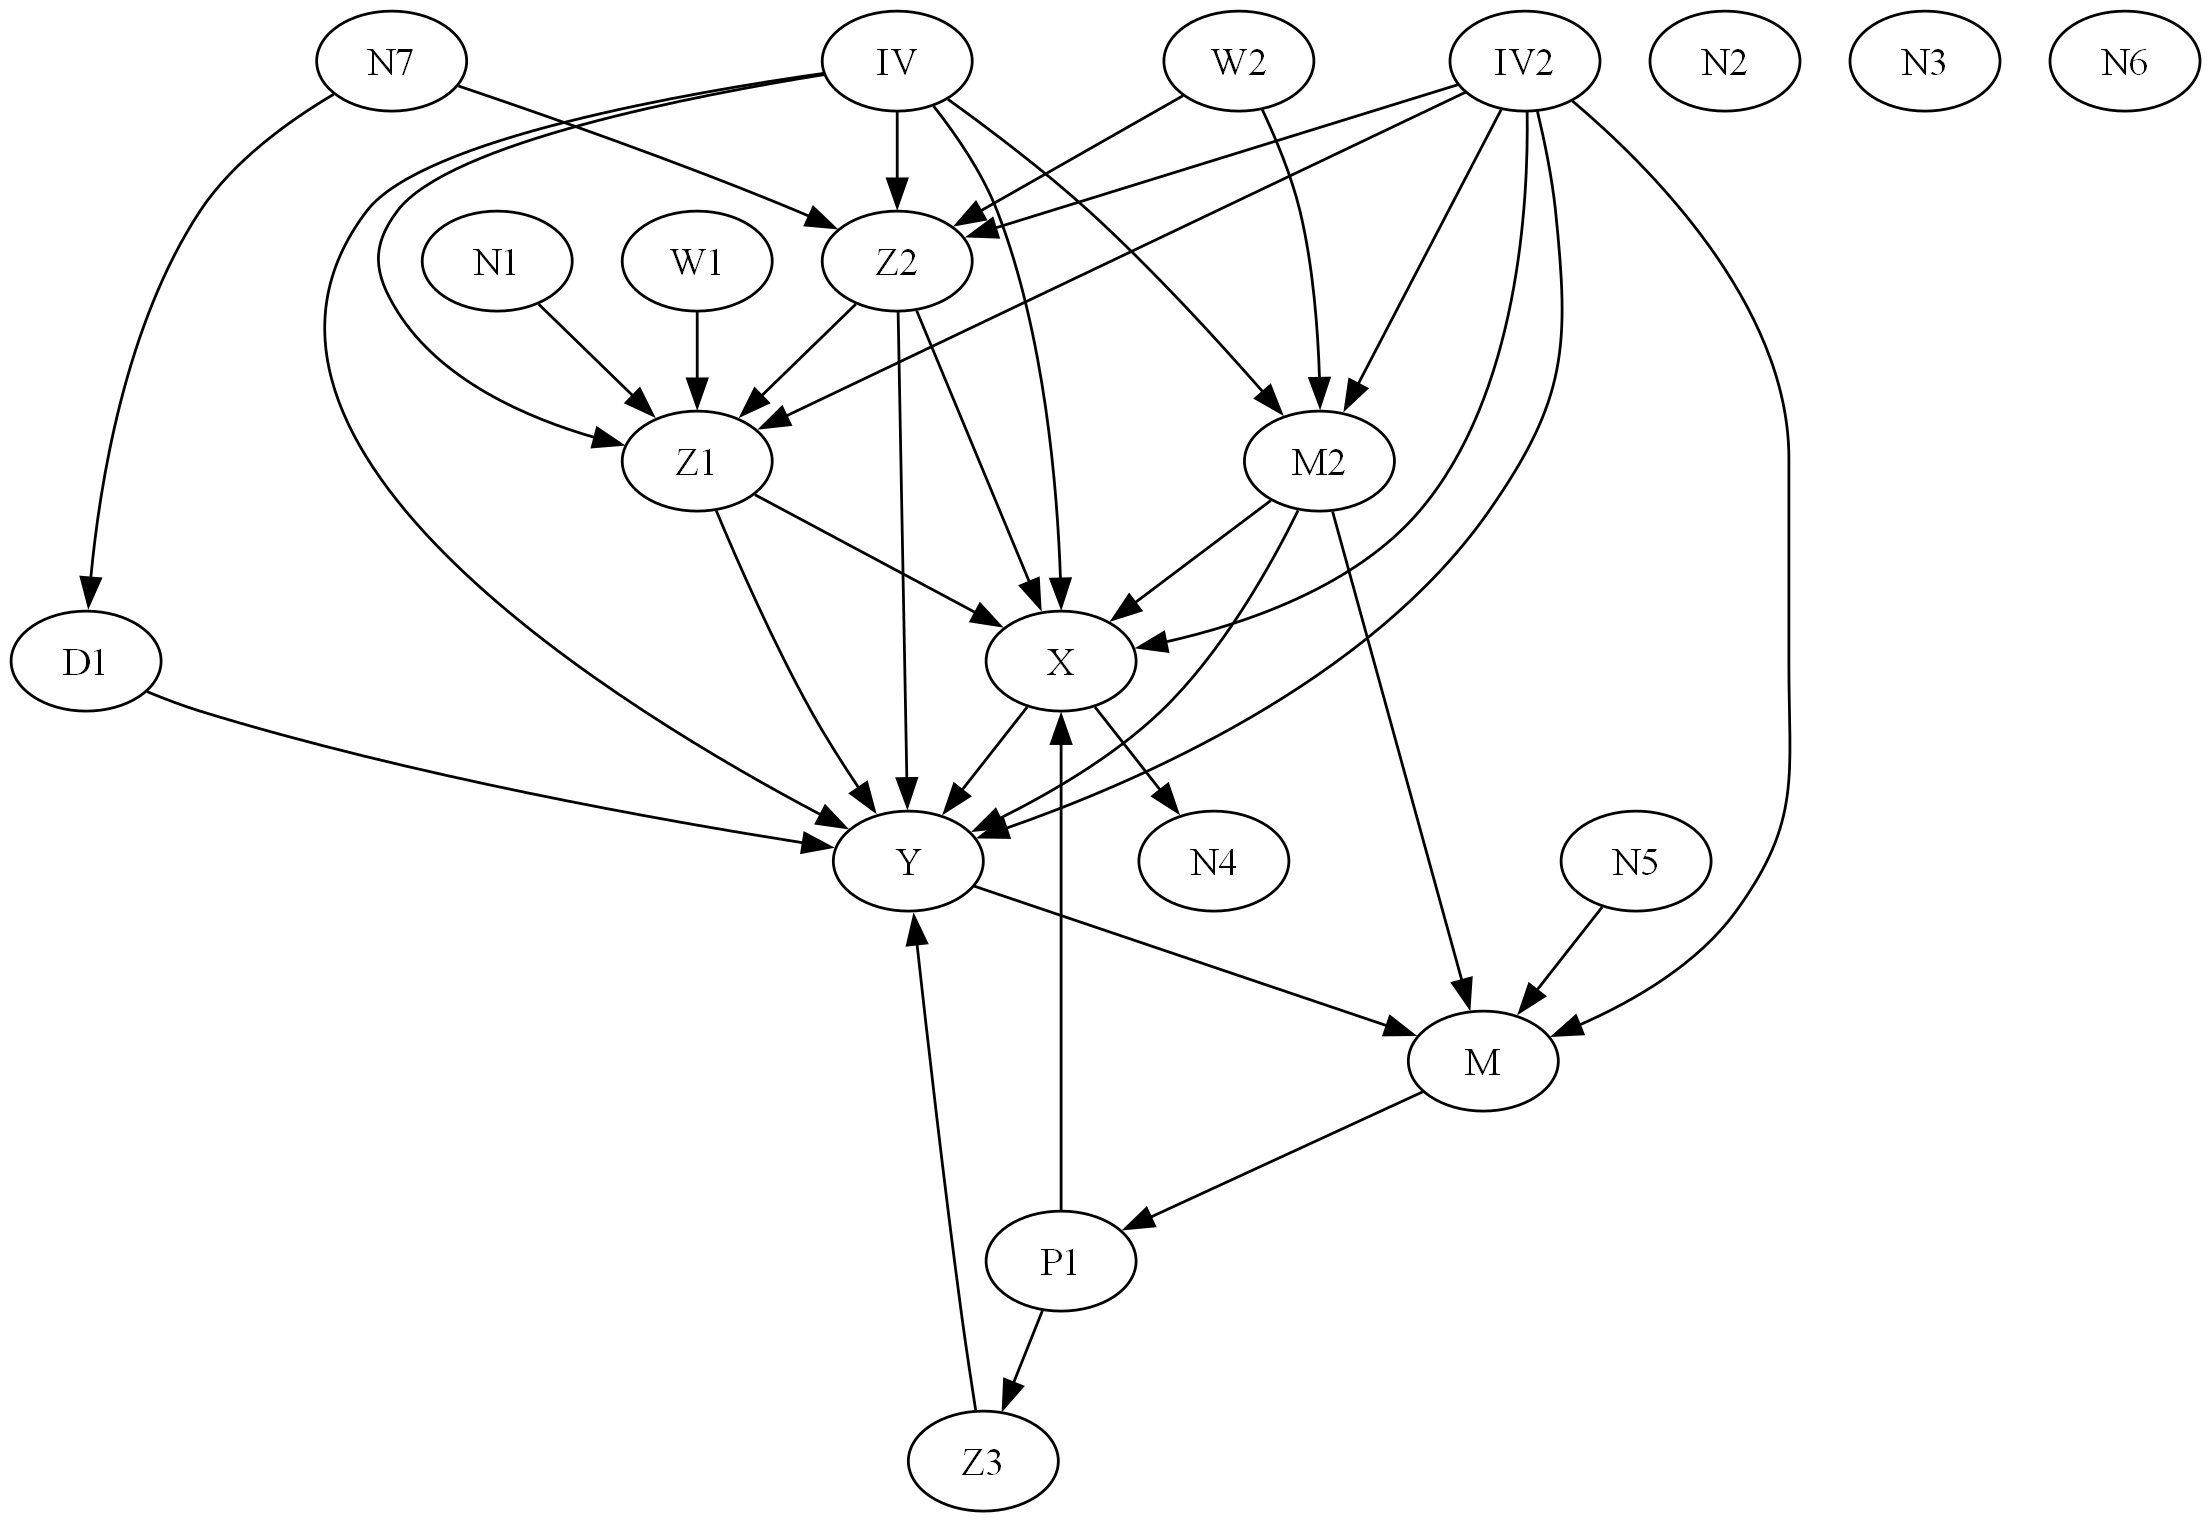

In [13]:
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.graph.GraphNode import GraphNode
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.Edge import Edge
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image, display

nodes = [GraphNode(name) for name in column_names]
lingam_graph = GeneralGraph(nodes)

for _, row in lingam_edges_df.iterrows():
    src_idx = column_names.index(row["From"])
    dst_idx = column_names.index(row["To"])
    lingam_graph.add_edge(
        Edge(nodes[src_idx], nodes[dst_idx], Endpoint.TAIL, Endpoint.ARROW)
    )

pyd = GraphUtils.to_pydot(lingam_graph, labels=column_names)
display(Image(pyd.create_png()))

### 8.4 LiNGAM と真の DAG の比較

In [14]:
lingam_estimated = {(e["From"], e["To"]) for _, e in lingam_edges_df.iterrows()}
lingam_skeleton = {frozenset(e) for e in lingam_estimated}

lingam_correct = true_skeleton & lingam_skeleton
lingam_missed = true_skeleton - lingam_skeleton
lingam_extra = lingam_skeleton - true_skeleton

print("=== LiNGAM: スケルトン (方向無視) の比較 ===")
print(f"真のエッジ数:     {len(true_skeleton)}")
print(f"推定エッジ数:     {len(lingam_skeleton)}")
print(f"正解 (一致):      {len(lingam_correct)}")
print(f"見逃し (FN):      {len(lingam_missed)}  {[set(e) for e in lingam_missed]}")
print(f"余分 (FP):        {len(lingam_extra)}  {[set(e) for e in lingam_extra]}")
if lingam_skeleton:
    l_precision = len(lingam_correct) / len(lingam_skeleton)
    l_recall = len(lingam_correct) / len(true_skeleton)
    l_f1 = 2 * l_precision * l_recall / (l_precision + l_recall) if (l_precision + l_recall) > 0 else 0
    print(f"Precision:        {l_precision:.4f}")
    print(f"Recall:           {l_recall:.4f}")
    print(f"F1:               {l_f1:.4f}")

=== LiNGAM: スケルトン (方向無視) の比較 ===
真のエッジ数:     21
推定エッジ数:     34
正解 (一致):      19
見逃し (FN):      2  [{'Z3', 'M'}, {'X', 'M'}]
余分 (FP):        15  [{'Z2', 'N7'}, {'IV', 'Z2'}, {'W2', 'M2'}, {'IV2', 'Z1'}, {'Y', 'IV2'}, {'Z2', 'IV2'}, {'Z3', 'P1'}, {'M2', 'IV2'}, {'M2', 'M'}, {'IV2', 'M'}, {'IV', 'Y'}, {'Z2', 'Z1'}, {'X', 'P1'}, {'IV', 'M2'}, {'IV', 'Z1'}]
Precision:        0.5588
Recall:           0.9048
F1:               0.6909


In [15]:
lingam_correct_directed = true_edges & lingam_estimated
lingam_reversed = {(b, a) for a, b in true_edges} & lingam_estimated

print("=== LiNGAM: 有向エッジの方向の比較 ===")
print(f"方向も正解:       {len(lingam_correct_directed)}  {lingam_correct_directed}")
print(f"方向が逆:         {len(lingam_reversed)}  {lingam_reversed}")

=== LiNGAM: 有向エッジの方向の比較 ===
方向も正解:       13  {('X', 'Y'), ('Z3', 'Y'), ('Z2', 'Y'), ('IV', 'X'), ('X', 'N4'), ('Z1', 'X'), ('M2', 'Y'), ('IV2', 'X'), ('D1', 'Y'), ('Z2', 'X'), ('W2', 'Z2'), ('Z1', 'Y'), ('W1', 'Z1')}
方向が逆:         6  {('Y', 'M'), ('M', 'P1'), ('N5', 'M'), ('N1', 'Z1'), ('M2', 'X'), ('N7', 'D1')}


In [16]:
lingam_parents_of_y = {e["From"] for _, e in lingam_edges_df.iterrows() if e["To"] == "Y"}

lingam_tp = true_direct_causes & lingam_parents_of_y
lingam_fn = true_direct_causes - lingam_parents_of_y
lingam_fp = lingam_parents_of_y - true_direct_causes

print("=== LiNGAM: Y の直接原因の特定精度 ===")
print(f"真の直接原因:     {sorted(true_direct_causes)}")
print(f"推定 (→ Y):       {sorted(lingam_parents_of_y)}")
print(f"正解 (TP):        {sorted(lingam_tp)}")
print(f"見逃し (FN):      {sorted(lingam_fn)}")
print(f"誤検出 (FP):      {sorted(lingam_fp)}")
print()
print(f"ノイズ変数 {sorted(NOISE_FEATURES)} が除外されたか: "
      f"{len(set(NOISE_FEATURES) & lingam_parents_of_y) == 0}")

=== LiNGAM: Y の直接原因の特定精度 ===
真の直接原因:     ['D1', 'M', 'M2', 'X', 'Z1', 'Z2', 'Z3']
推定 (→ Y):       ['D1', 'IV', 'IV2', 'M2', 'X', 'Z1', 'Z2', 'Z3']
正解 (TP):        ['D1', 'M2', 'X', 'Z1', 'Z2', 'Z3']
見逃し (FN):      ['M']
誤検出 (FP):      ['IV', 'IV2']

ノイズ変数 ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7'] が除外されたか: True


## 9. PC vs LiNGAM 比較まとめ

In [17]:
pc_prec = len(correct_skeleton) / len(pc_skeleton) if pc_skeleton else 0
pc_rec = len(correct_skeleton) / len(true_skeleton)
pc_f1 = 2 * pc_prec * pc_rec / (pc_prec + pc_rec) if (pc_prec + pc_rec) > 0 else 0

if lingam_skeleton:
    l_precision = len(lingam_correct) / len(lingam_skeleton)
    l_recall = len(lingam_correct) / len(true_skeleton)
    l_f1 = 2 * l_precision * l_recall / (l_precision + l_recall) if (l_precision + l_recall) > 0 else 0
else:
    l_precision = l_recall = l_f1 = 0

comparison = pd.DataFrame({
    "指標": [
        "検出エッジ数",
        "スケルトン Precision",
        "スケルトン Recall",
        "スケルトン F1",
        "方向正解数",
        "方向逆転数",
        "Y の直接原因 TP",
        "Y の直接原因 FN",
        "Y の直接原因 FP",
        "ノイズ除外",
    ],
    "PC": [
        len(pc_edges_df),
        f"{pc_prec:.4f}",
        f"{pc_rec:.4f}",
        f"{pc_f1:.4f}",
        len(correct_directed),
        len(reversed_directed),
        len(pc_tp),
        len(pc_fn),
        len(pc_fp),
        len(set(NOISE_FEATURES) & pc_adjacent_to_y) == 0,
    ],
    "LiNGAM": [
        len(lingam_edges_df),
        f"{l_precision:.4f}",
        f"{l_recall:.4f}",
        f"{l_f1:.4f}",
        len(lingam_correct_directed),
        len(lingam_reversed),
        len(lingam_tp),
        len(lingam_fn),
        len(lingam_fp),
        len(set(NOISE_FEATURES) & lingam_parents_of_y) == 0,
    ],
})

print("=" * 60)
print("PC アルゴリズム vs DirectLiNGAM 比較")
print("=" * 60)
print(f"真のエッジ数: {len(true_skeleton)}")
print(f"真の Y の直接原因: {sorted(true_direct_causes)}")
print(f"ブートストラップ回数: {n_bootstrap} (PC / LiNGAM 共通)")
print(f"エッジ採用閾値: 出現確率 >= {THRESHOLD}")
print()
print(comparison.to_string(index=False))
print()
print("注: DGP のノイズはガウス分布のため LiNGAM の仮定を満たさない。")
print("   実データでは分布に応じて手法を選択する必要がある。")

PC アルゴリズム vs DirectLiNGAM 比較
真のエッジ数: 21
真の Y の直接原因: ['D1', 'M', 'M2', 'X', 'Z1', 'Z2', 'Z3']
ブートストラップ回数: 100 (PC / LiNGAM 共通)
エッジ採用閾値: 出現確率 >= 0.5

             指標     PC LiNGAM
         検出エッジ数     19     34
スケルトン Precision 0.9474 0.5588
   スケルトン Recall 0.8571 0.9048
       スケルトン F1 0.9000 0.6909
          方向正解数     14     13
          方向逆転数      0      6
     Y の直接原因 TP      5      6
     Y の直接原因 FN      2      1
     Y の直接原因 FP      1      2
          ノイズ除外   True   True

注: DGP のノイズはガウス分布のため LiNGAM の仮定を満たさない。
   実データでは分布に応じて手法を選択する必要がある。
